In [4]:
path = 'raw_demo_plots/connectedness/'

In [5]:
from matplotlib.mlab import griddata
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams

title_sz = 27
axis_sz = 22
tick_sz = 21
rcParams.update({'font.size': tick_sz-4}) # Increase font-size

import matplotlib.cm as cm

import numpy as np
from numpy import linspace
from numpy import meshgrid

import pylab as pl
from collections import defaultdict

from scipy import stats
from scipy.interpolate import UnivariateSpline
from scipy.signal import argrelextrema

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [6]:
from chem_ocean.ocean_data import dataFetcher
from chem_ocean.ocean_plt import rawPlotter
from chem_ocean.ocean_plt_util import save_name
import chem_ocean.ocean_analysis as oc_an

In [7]:
class water_column():
    
    def __init__(self, dataset, traj_type, **kwargs):
        self.traj_type = traj_type
        self.char_values = []
        self.char_points = []
        self._ax_smooth = []
        self._d = dataset._d
        self._x = dataset._x
        self._y = dataset._y
        self._feat_data = dataset._feat_data
        self.ordered_by = 'd'
        ax = self._d
        
        if 'depth' in kwargs: #creates a horizontal water column at some depth 
            self._feat_data = dataset._feat_data[dataset._d == kwargs['depth']]
            self._x = dataset._x[dataset._d == kwargs['depth']]
            self._y = dataset._y[dataset._d == kwargs['depth']]
            self._d = dataset._d[dataset._d == kwargs['depth']]
            
            self._y = self._y[np.argsort(self._x[:])]
            self._d = self._d[np.argsort(self._x[:])]
            self._feat_data = self._feat_data[np.argsort(self._x[:])]
            self._x = self._x[np.argsort(self._x[:])]
            self.ordered_by = 'x'
            ax = self._x
    
        _ax = []
        _feat_data = []
        for ik in range(len(ax)):
            if ax[ik] not in _ax:
                _ax.append(ax[ik])
                #change this to pull the median value if there are multiple values for a given depth
                _feat_data.append(np.mean(self._feat_data[ax == ax[ik]]))#ik])
                
        self._ax_avgd = np.array(_ax)
        self._feat_data_avgd = np.array(_feat_data)
        self._feat_data_smooth = []
        self._feat_data_smooth_d1 = []
        self.extrema_d1 = []
        self.extrema_d2 = []
        self.mixing_labels = []
        self.mixing_ratios = []
        
    def smooth_data(self):

        spl = UnivariateSpline(self._ax_avgd, self._feat_data_avgd)
        if self.traj_type == 'traj':
            spl.set_smoothing_factor(0.01)
        else:
            spl.set_smoothing_factor(0.001)
            
        numpts = len(self._ax_avgd)/2
        self._ax_smooth = np.linspace(min(self._ax_avgd), max(self._ax_avgd), num=numpts, endpoint=True)
        self._feat_data_smooth = spl(self._ax_smooth)

        self._feat_data_smooth_d1 = np.gradient(self._feat_data_smooth,self._ax_smooth)
    
    #characteristic values (values at depths where the concentration doesn't change):
    def get_char_values(self):
        self.smooth_data()
            
        self.extrema_d1 = np.unique(np.sort(np.concatenate([argrelextrema(self._feat_data_smooth, np.greater, mode="wrap")[0], argrelextrema(self._feat_data_smooth, np.less, mode="wrap")[0], [len(self._feat_data_smooth)-1]])))
        self.extrema_d2 = np.unique(np.sort(np.concatenate([argrelextrema(self._feat_data_smooth_d1, np.greater, mode="wrap")[0], argrelextrema(self._feat_data_smooth_d1, np.less, mode="wrap")[0], [len(self._feat_data_smooth)-1]])))

        char_values = []
        points = [] #depths
        ik = 0
        while ik< len(self.extrema_d2)-1:
            min_ind = find_closest(self._ax_avgd, self._feat_data_avgd, self._ax_smooth[self.extrema_d2[ik]])
            max_ind = find_closest(self._ax_avgd, self._feat_data_avgd, self._ax_smooth[self.extrema_d2[ik+1]])
            if min_ind != max_ind:
                label, value, point = classify(self._ax_avgd, self._feat_data_avgd,min_ind, max_ind)
                if label in ['max', 'min'] and (point not in points):
                    char_values.append(value)
                    points.append(point)
            ik +=1
        
        self.char_values = np.array(char_values)
        self.char_points = np.array(points)
        
        if np.argmin(self._feat_data_avgd) not in self.char_points:
            self.char_values = np.concatenate([self.char_values, np.array([min(self._feat_data_avgd)])])
            self.char_points = np.concatenate([self.char_points, np.array([np.argmin(self._feat_data_avgd)])])
        if np.argmax(self._feat_data_avgd) not in self.char_points:
            self.char_values = np.concatenate([self.char_values, np.array([max(self._feat_data_avgd)])])
            self.char_points = np.concatenate([self.char_points, np.array([np.argmax(self._feat_data_avgd)])])

        self.char_values = self.char_values[np.argsort(self.char_points)]
        self.char_points = np.sort(self.char_points)
                
    def get_mixing_labels(self, mode):
        if len(self.char_values)==0:
            self.get_char_values()
        ax = self._ax_avgd
        
        ik = 0
        colors = [('r', 'b'), ('b', 'y'), ('y', 'm'), ('m', 'g'), ('g', 'c'),('c','k')]
        color = []
        depth = ax[0]
        
        # two endmember mixing model
        if mode == 'two_endmember':
            mixing_ratios = [np.zeros(2) for ik in range(len(ax))]
            u_char = 34.652698999999998 
            l_char = 34.939200999999997
            for ik in range(len(ax)):
                mixing_ratios[ik][0] = max(min((self._feat_data_avgd[ik]-l_char)/(u_char-l_char), 1), 0)
                mixing_ratios[ik][1] = 1-mixing_ratios[ik][0]
                if mixing_ratios[ik][0] >= .5:
                    color.append(colors[0][0])
                else:
                    color.append(colors[0][1])
                ik+=1
                
        else:
            mixing_ratios = [np.zeros(len(self.char_values)) for ik in range(len(ax))]
            for ip in range(len(self.char_values)-1):
                lower_bnd = ax[int(self.char_points[ip+1])]
                u_char = self.char_values[ip]
                l_char = self.char_values[ip+1]
                while (depth < lower_bnd) and (ik<len(ax)):
                    depth = ax[ik]
    #                 c_1 = max(min((self._feat_data[ik]-l_char)/(u_char-l_char), 1), 0)
                    mixing_ratios[ik][ip] = max(min((self._feat_data_avgd[ik]-l_char)/(u_char-l_char), 1), 0)
                    mixing_ratios[ik][ip+1]= 1-mixing_ratios[ik][ip]
                    if mixing_ratios[ik][ip] >= .5:
                        color.append(colors[ip][0])
                    else:
                        color.append(colors[ip][1])
                    ik+=1
        self.mixing_labels = color
        self.mixing_ratios = mixing_ratios

In [8]:
def find_closest(_ax, _feat_data, pt):
    ik = 0
    while ik<len(_ax):
        if pt>_ax[ik]:
            ik+=1
        else:
            return ik


def classify(_ax, _feat_data, min_ind, max_ind):
    margin = 3#int(np.floor((max_ind-min_ind)/8))
    try:
        m1 = (_feat_data[min_ind+margin]-_feat_data[min_ind])/(_ax[min_ind+margin]-_ax[min_ind])
        m2 = (_feat_data[max_ind]-_feat_data[max_ind-margin])/(_ax[max_ind]-_ax[max_ind-margin])
#         print(m1, m2, min_ind, max_ind)
#         if  min_ind !=max_ind:
        if (m1 >0 and m2<0):
            return 'max', max(_feat_data[min_ind:max_ind]), np.argmax(_feat_data[min_ind:max_ind])+ min_ind
        elif (m1>0 and m2>0) or (m1<0 and m2<0):
            return 'neither', min(_feat_data[min_ind:max_ind]), min_ind
        else:
            return 'min', min(_feat_data[min_ind:max_ind]), np.argmin(_feat_data[min_ind:max_ind]) + min_ind
    except:
        return 'endpt?', _feat_data[min_ind], np.argmin(_feat_data[min_ind:max_ind]) + min_ind


In [9]:
class minisection:
    ''' 
    outputs a minisection with all tracer data over a short trajectory at each specified depth. 
    depths are determined by the d_traj
    '''
    
    def __init__(self, d_traj, nlat, slat):
        self.depth_bins = d_traj.keys()
        self.nlat = nlat
        self.slat = slat
        self.d = {}
        for depth in self.depth_bins:
#             self.d[depth] =d_traj[depth]._feat_data_avgd[d_traj[depth]._ax_avgd>nlat] # pull averaged feature data from some depth that is 
            self.d[depth] =d_traj[depth]._feat_data_avgd[(d_traj[depth]._ax_avgd<nlat) &(d_traj[depth]._ax_avgd>slat) ] # pull averaged feature data from some depth that is 

#             print(depth, nlat, slat, self.d[depth])
#             self.d[pair[1]] =d_traj[pair[1]]._feat_data_avgd[d_traj[pair[1]]._ax_avgd>nlat]


In [10]:
class paths:
    
    def __init__(self, connectivity_window, minisections, pthresh1, pthresh2):
        
        self.window = connectivity_window
        self.pthresh1 = pthresh1
        self.pthresh2 = pthresh2
        self.d_paths = {}
        
        for ik in range(len(minisections)-1):
            mini_sec1 = minisections[ik]
            mini_sec2 = minisections[ik+1]
            for depth1 in mini_sec1.depth_bins:
                self.d_paths[(mini_sec1.slat,depth1)]= []
                try:
                    t, p = stats.ttest_ind(mini_sec1.d[depth1+500],mini_sec1.d[depth1], equal_var=False)
                    if p>self.pthresh1:
                        if p>self.pthresh2:
                            self.d_paths[(mini_sec1.slat,depth1)].append((mini_sec1.slat,depth1+500, p))
                        else:
                            self.d_paths[(mini_sec1.slat,depth1)].append((mini_sec1.slat,depth1+500, p))
                except:
                    continue
                for depth2 in mini_sec2.depth_bins:
                    if (depth2 <= depth1+self.window) and (depth2 >= depth1-self.window):
                        t, p = stats.ttest_ind(mini_sec2.d[depth2],mini_sec1.d[depth1], equal_var=False)
                        if p>self.pthresh1:
                            if p>self.pthresh2:
                                self.d_paths[(mini_sec1.slat,depth1)].append((mini_sec2.slat,depth2, p))
                            else:
                                self.d_paths[(mini_sec1.slat,depth1)].append((mini_sec2.slat,depth2, p))



In [11]:
lat_bins = [
    (68, 62), 
    (62, 55),
    (55, 40),
    (40, 20),
    (20, 0),
    (0,-20),
    (-20,-40),
    (-40,-55),
    (-55,-62),
    (-68,-62)
]

depths = [250, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]



In [8]:
lat_bins = [(x, x+3) for x in range(-80,80, 3)]
depths = [x for x in range(250,6500, 250)]

In [11]:
dataset = dataFetcher()
dataset.get_plan([-70, 70],[-40, -15], ['salinity'], 1500)

In [16]:
lons = np.unique(dataset._x)

In [17]:
lats = np.unique(dataset._y)

In [19]:
matrix = np.empty((len(lats), len(lons)))

In [20]:
d = {}
for ik in range(len(dataset._x)):
    d[(dataset._x[ik], dataset._y[ik])] = dataset._feat_data[ik]

dict_keys([(-39.5, -69.5), (-38.5, -69.5), (-37.5, -69.5), (-36.5, -69.5), (-35.5, -69.5), (-34.5, -69.5), (-33.5, -69.5), (-32.5, -69.5), (-31.5, -69.5), (-30.5, -69.5), (-29.5, -69.5), (-28.5, -69.5), (-27.5, -69.5), (-26.5, -69.5), (-25.5, -69.5), (-24.5, -69.5), (-23.5, -69.5), (-22.5, -69.5), (-21.5, -69.5), (-20.5, -69.5), (-19.5, -69.5), (-18.5, -69.5), (-17.5, -69.5), (-16.5, -69.5), (-15.5, -69.5), (-39.5, -68.5), (-38.5, -68.5), (-37.5, -68.5), (-36.5, -68.5), (-35.5, -68.5), (-34.5, -68.5), (-33.5, -68.5), (-32.5, -68.5), (-31.5, -68.5), (-30.5, -68.5), (-29.5, -68.5), (-28.5, -68.5), (-27.5, -68.5), (-26.5, -68.5), (-25.5, -68.5), (-24.5, -68.5), (-23.5, -68.5), (-22.5, -68.5), (-21.5, -68.5), (-20.5, -68.5), (-19.5, -68.5), (-18.5, -68.5), (-17.5, -68.5), (-16.5, -68.5), (-15.5, -68.5), (-39.5, -67.5), (-38.5, -67.5), (-37.5, -67.5), (-36.5, -67.5), (-35.5, -67.5), (-34.5, -67.5), (-33.5, -67.5), (-32.5, -67.5), (-31.5, -67.5), (-30.5, -67.5), (-29.5, -67.5), (-28.5, -67.5

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


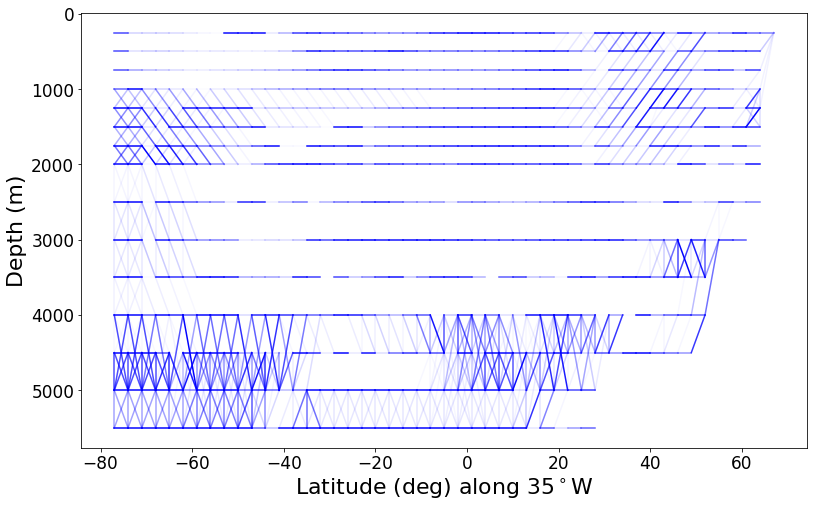

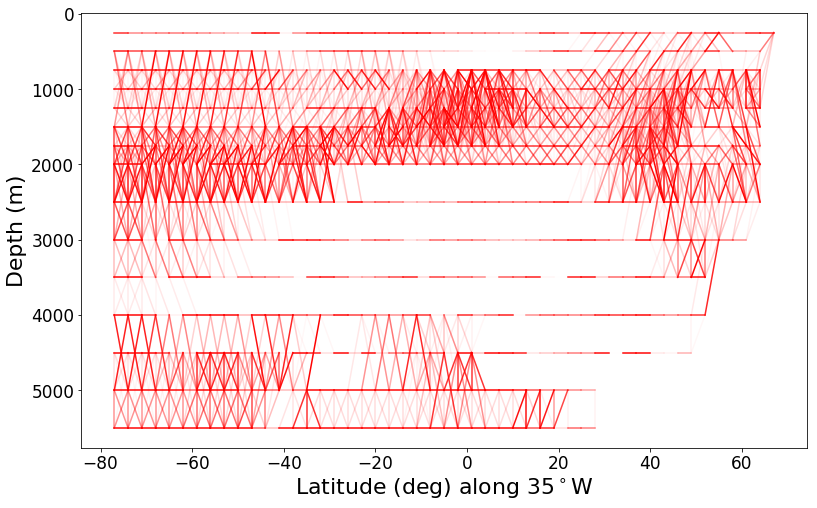

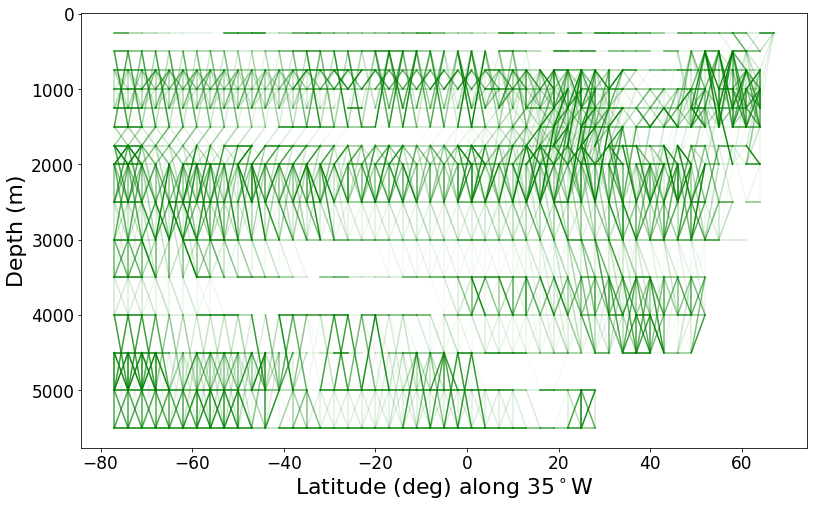

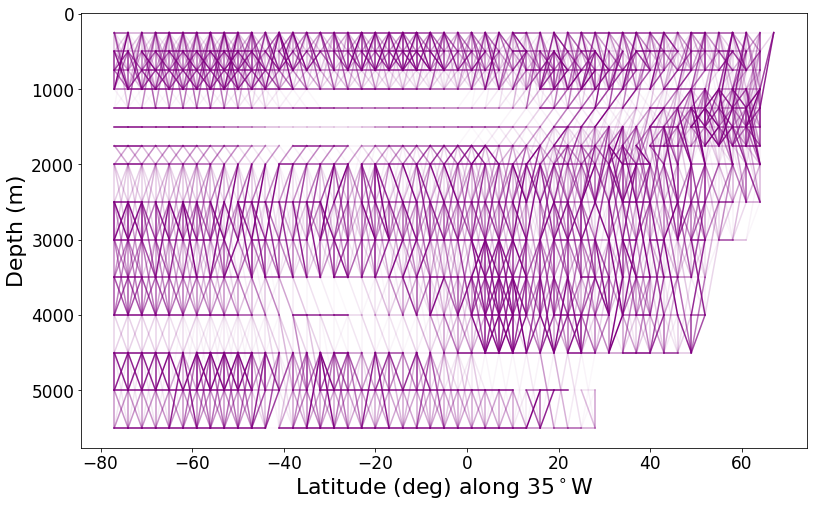

In [19]:
ptlat, ptlon = -58, -25
lineLon = -35
minLat, maxLat = -80, 80

tracer_d = {'temperature':'blue', 'salinity': 'red', 'phosphate': 'green', 'oxygen':'purple'}

for tracer in tracer_d.keys():
    dataset = dataFetcher()
    # dataset.get_plan([-70, 70],[-180, 180], [tracer], 1500)
    dataset.get_section('NS_section', lineLon, [minLat, maxLat], [tracer])
    
    d_traj = {}
    for dpth in depths:
        Atl = water_column(dataset, 'traj', depth= dpth) # create horizontal water columns at some depth
        d_traj[dpth] = Atl

    minisections = []
    for (nlat, slat) in lat_bins:
        minisections.append(minisection(d_traj, nlat, slat)) #

    Atl_paths = paths(1000, minisections, .01, .05)
    
    fig = plt.figure(figsize = (13, 8)) 
    ax = fig.add_subplot(111)
    for key in Atl_paths.d_paths.keys():
        values = Atl_paths.d_paths[key]
        for value in values:
            ax.plot([key[0], value[0]],[key[1], value[1]], c = tracer_d[tracer] ,alpha = 1-(1-3*value[2]) )
    ax.set_ylabel('Depth (m)', fontsize=axis_sz)
    ax.set_xlabel('Latitude (deg) along {}$^\circ$W'.format(-lineLon), fontsize=axis_sz)

    # set tick parameters
    xtickNames = ax.get_xticklabels()
    ytickNames = ax.get_yticklabels()
    
    for names in [ytickNames, xtickNames]:
        plt.setp(names, rotation=0, fontsize=tick_sz-4)
#     ax.set_title(tracer)
    plt.gca().invert_yaxis()
    
    name1 = tracer+'_connectedness_'+str(-lineLon)+'W'
    plt.savefig(path+name1+'.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


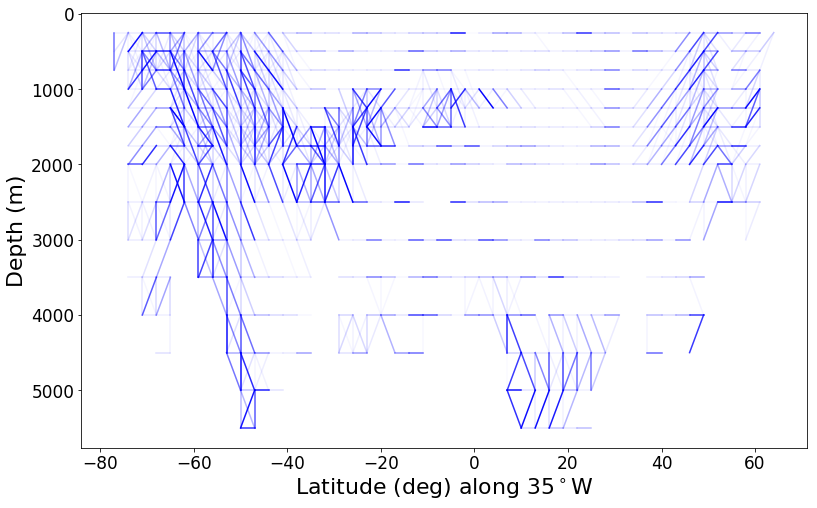

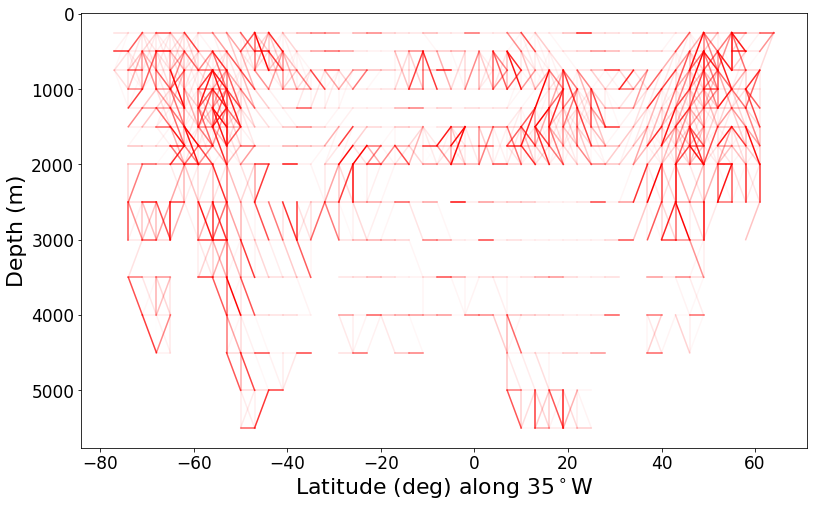

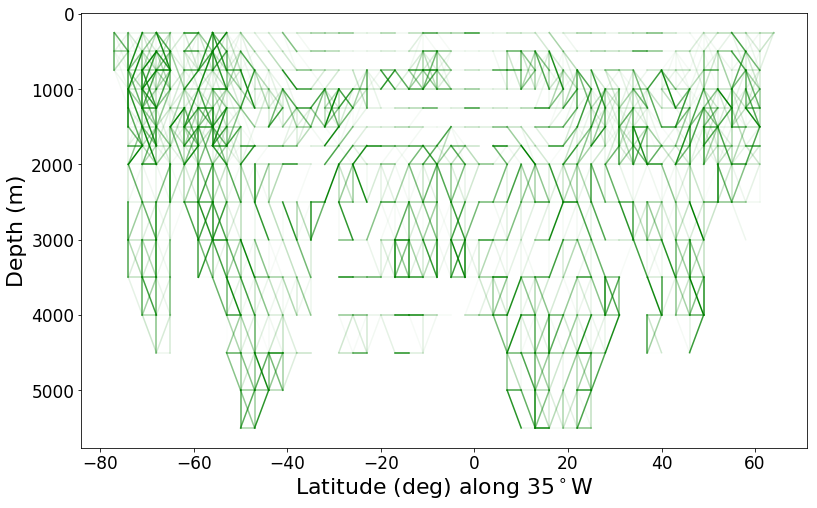

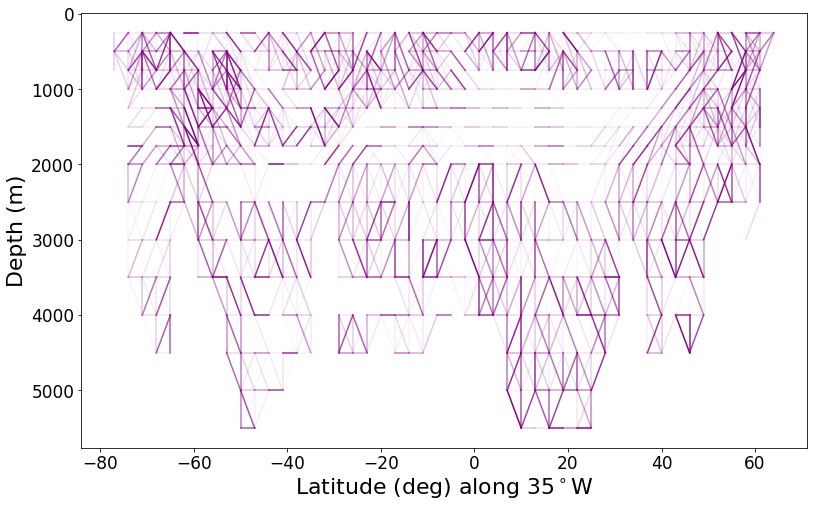

In [45]:
ptlat, ptlon = -58, -25
lineLon = -35
minLat, maxLat = -80, 80

tracer_d = {'temperature':'blue', 'salinity': 'red', 'phosphate': 'green', 'oxygen':'purple'}

for tracer in tracer_d.keys():
    dataset = dataFetcher()
    # dataset.get_plan([-70, 70],[-180, 180], [tracer], 1500)
    dataset.get_section('NS_section', lineLon, [minLat, maxLat], [tracer])
    
    d_traj = {}
    # standardize the depths of interest between locations
    for dpth in depths:
        Atl = water_column(dataset, 'traj', depth= dpth) 
        d_traj[dpth] = Atl

    minisections = []
    for (slat, nlat) in lat_bins:
        minisections.append(minisection(d_traj, nlat, slat)) #

    Atl_paths = paths(500, minisections, .01, .05)
    
    fig = plt.figure(figsize = (13, 8)) 
    ax = fig.add_subplot(111)
    for key in Atl_paths.d_paths.keys():
        values = Atl_paths.d_paths[key]
        for value in values:
            ax.plot([key[0], value[0]],[key[1], value[1]], c = tracer_d[tracer] ,alpha = 1-(1-3*value[2]) )
    ax.set_ylabel('Depth (m)', fontsize=axis_sz)
    ax.set_xlabel('Latitude (deg) along {}$^\circ$W'.format(-lineLon), fontsize=axis_sz)

    # set tick parameters
    xtickNames = ax.get_xticklabels()
    ytickNames = ax.get_yticklabels()
    
    for names in [ytickNames, xtickNames]:
        plt.setp(names, rotation=0, fontsize=tick_sz-4)
#     ax.set_title(tracer)
    plt.gca().invert_yaxis()
    
#     name1 = tracer+'_connectedness_'+str(-lineLon)+'W'
#     plt.savefig(path+name1+'.png', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None)

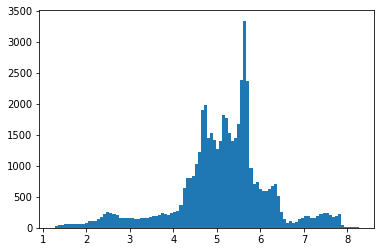

In [66]:
import pandas as pd
counts, bin_edges, patches = plt.hist(dataset._feat_data, bins = 100)

bin_nums = []
for point in dataset._feat_data:
    ik = 0
    while point > bin_edges[ik]
        ik+=1
    bin_nums.append(ik)

## End-member mixing experiments

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


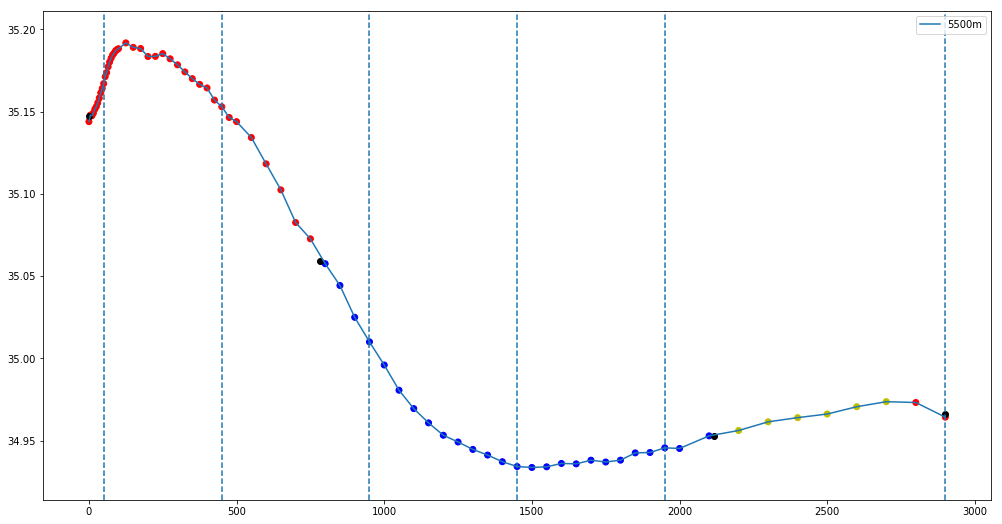

In [591]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 9), facecolor='w')

Atl = water_column(dataset2, 'column')
Atl.get_char_values()

Atl.get_mixing_labels('n_endmembers')
# d_traj[dpth] = Atl
ax.scatter(Atl._ax_avgd, Atl._feat_data_avgd, c = Atl.mixing_labels)
ax.plot(Atl._ax_avgd, Atl._feat_data_avgd, label = str(dpth)+'m')
ax.scatter(Atl._ax_smooth[Atl.extrema_d2], Atl._feat_data_smooth[Atl.extrema_d2], color='k')

for interval in intervals:
    plt.axvline(x = interval, linestyle='--')
plt.legend()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


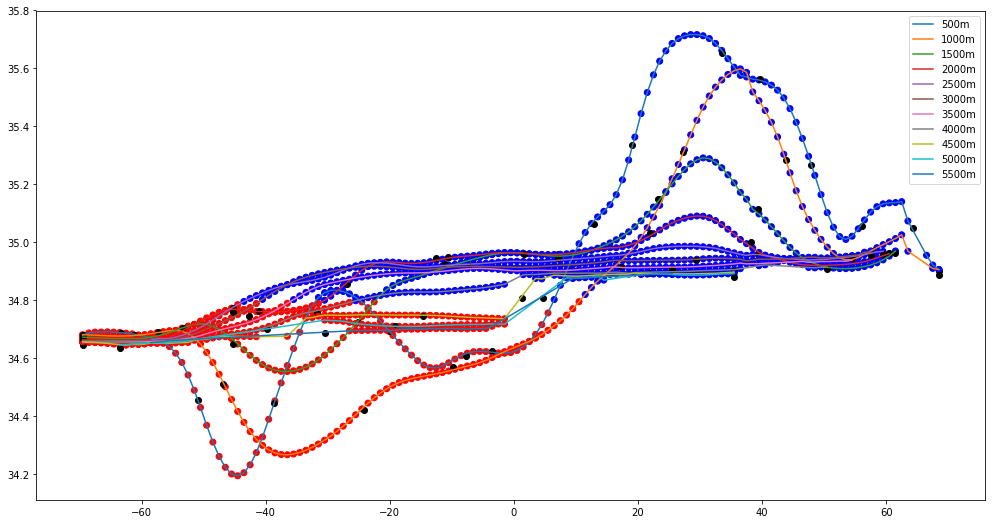

In [25]:
# dataset_SA = dataFetcher()
# dataset_SA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <-50 and latitude > -70 and longitude < -20 and longitude >-40 order by depth'.format(tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')
# currently trying to come up with mixing trajectories along _x
# fig, ax = plt.figure(nrows=1, ncols=1,figsize=(10+6, 9))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 9), facecolor='w')


# ax = fig.add_subplot()

depths = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500]
d_traj = {}
for dpth in depths:
    Atl = water_column(dataset, 'traj', depth= dpth)
    Atl.get_char_values()

    Atl.get_mixing_labels('two_endmember')
    d_traj[dpth] = Atl
#     ax.scatter(Atl._x, Atl._feat_data, c = Atl.mixing_labels)
#     ax.plot(Atl._x, Atl._feat_data, label = str(dpth)+'m')
    ax.scatter(Atl._ax_avgd, Atl._feat_data_avgd, c = Atl.mixing_labels)
    ax.plot(Atl._ax_avgd, Atl._feat_data_avgd, label = str(dpth)+'m')
    ax.scatter(Atl._ax_smooth[Atl.extrema_d2], Atl._feat_data_smooth[Atl.extrema_d2], color='k')



plt.legend()
# ax.set_ylim([34.64, 34.68])

depth: 2500
depth: 3000
depth: 3500
depth: 4000
depth: 4500
depth: 5000
depth: 5500


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


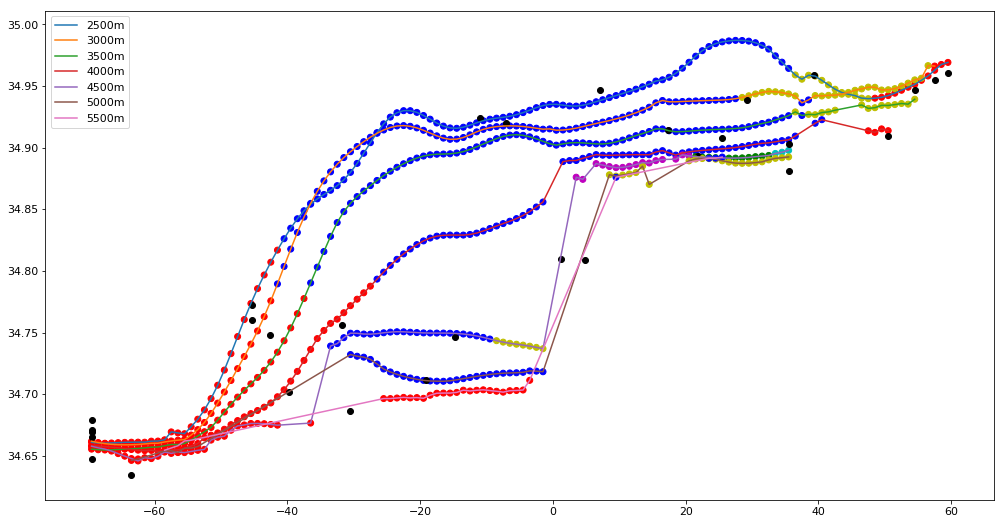

In [11]:
# dataset_SA = dataFetcher()
# dataset_SA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <-50 and latitude > -70 and longitude < -20 and longitude >-40 order by depth'.format(tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')
#currently trying to come up with mixing trajectories along _x
# fig, ax = plt.figure(nrows=1, ncols=1,figsize=(10+6, 9))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 9), facecolor='w')


# ax = fig.add_subplot()

depths = [2500, 3000, 3500, 4000, 4500, 5000, 5500]
d_traj = {}
for dpth in depths:
    Atl = water_column(dataset, 'traj', depth= dpth)
    Atl.get_char_values()

    Atl.get_mixing_labels('n_members')
    d_traj[dpth] = Atl
#     ax.scatter(Atl._x, Atl._feat_data, c = Atl.mixing_labels)
#     ax.plot(Atl._x, Atl._feat_data, label = str(dpth)+'m')
    ax.scatter(Atl._ax_avgd, Atl._feat_data_avgd, c = Atl.mixing_labels)
    ax.plot(Atl._ax_avgd, Atl._feat_data_avgd, label = str(dpth)+'m')
    ax.scatter(Atl._ax_smooth[Atl.extrema_d2], Atl._feat_data_smooth[Atl.extrema_d2], color='k')



plt.legend()
# ax.set_ylim([34.64, 34.68])

In [553]:
intervals = column_split_ptest(Atl._feat_data_avgd,Atl._ax_avgd)

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [567]:
def column_split_ptest(_feat_data, _d, **kwargs):
    sample_size = 10
    lower_bound = max(_d)
    lower_increment = 100
    n_1 = 1
    middle_bound = lower_bound - n_1*lower_increment
    upper_increment = 100
    n_2 = 1
    upper_bound = middle_bound - n_2*upper_increment

    intervals = [lower_bound]
        
    while upper_bound >0:
        n_1 = 1
        middle_bound = lower_bound - n_1*lower_increment
        n_2 = 1
        upper_bound = middle_bound - n_2*upper_increment

        tracer_lower = _feat_data[np.logical_and((_d<lower_bound) , (_d >= middle_bound))]
        tracer_upper = _feat_data[np.logical_and((_d<middle_bound) , (_d >= upper_bound))]

        p2 = 1
        
        #split into upper and lower sections with at least 30 data points each
        while p2>.01 or len(tracer_lower)<sample_size or len(tracer_upper)<sample_size:
            if len(tracer_lower) < sample_size or  p2>.01:
                n_1+=.5
                middle_bound = lower_bound - n_1*lower_increment
                tracer_lower = _feat_data[np.logical_and((_d<lower_bound) , (_d >= middle_bound))]

                if middle_bound - n_2*upper_increment != upper_bound:
                    n_2 = .5
                    upper_bound = middle_bound - n_2*upper_increment
                    tracer_upper = _feat_data[np.logical_and((_d<middle_bound) , (_d >= upper_bound))]
                    while len(tracer_upper) < sample_size:
                        n_2+=.5
                        upper_bound = middle_bound - n_2*upper_increment
                        tracer_upper = _feat_data[np.logical_and((_d<middle_bound) , (_d >= upper_bound))]

            # test to see if they are significantly different
            t2, p2 = stats.ttest_ind(tracer_upper,tracer_lower)

        intervals.append(middle_bound)
        lower_bound = middle_bound
        
    return intervals#, fig, ax

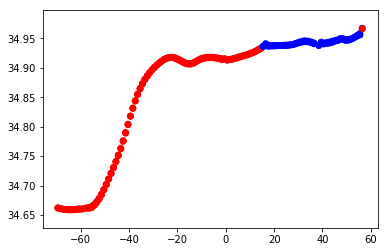

In [246]:
plt.scatter(NAtl_60._x, NAtl_60._feat_data, c = NAtl_60.mixing_labels)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SADeprecationWarning: reflect=True is deprecate; please use the reflect() method.


salinity 3500 377.073602442 0.0
p-value is so small that there is only a miniscule chance that these two samples could have been picked from the same population


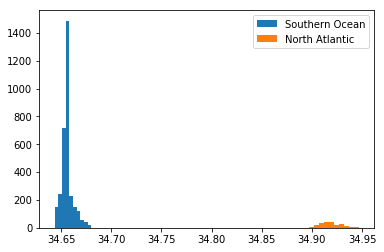

In [565]:
depth = 3500
tracer = 'salinity'

dataset_NA = dataFetcher()
dataset_NA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <70 and latitude > 50 and longitude < -20 and longitude >-40 order by depth'.format(tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')

dataset_SA = dataFetcher()
dataset_SA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <-50 and latitude > -70 and longitude < -20 and longitude >-40 order by depth'.format(tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')

data_NA = dataset_NA._feat_data[dataset_NA._d>depth]
data_SA = dataset_SA._feat_data[dataset_SA._d>depth]

t2, p2 = stats.ttest_ind(data_NA,data_SA, equal_var=False)
print(tracer,depth, t2, p2)


plt.hist(data_SA, label = 'Southern Ocean')
plt.hist(data_NA, label = 'North Atlantic')

plt.legend(prop={'size': 10})

print('p-value is so small that there is only a miniscule chance that these two samples could have been picked from the same population')

Based on the plot of the section along 25W, we can see structure in the water column, and from that we could reasonably expect that deep water tracer values might differ between North and South Atlantic. However, this should be discernable mathematically.  

Suppose we analyze along a line of longitude rather than depth at, say, 3000m, 3500m, 4000m, 4500m, 5000m, and see how the trajectories shake out with respect to latitude.

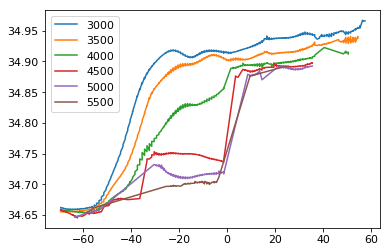

In [11]:
# test case
ptlat, ptlon = 58, -25
lineLon = -25
minLat, maxLat = -70, 80
tracer = 'salinity'

section_dataset = dataFetcher()
section_dataset.get_section('NS_section', lineLon, [minLat, maxLat], [tracer])
    
depths = [3000, 3500, 4000, 4500, 5000, 5500]
for depth in depths:
    plt.plot(section_dataset._x[section_dataset._d==depth], section_dataset._feat_data[section_dataset._d==depth], label=str(depth))
    
plt.legend()

salinity


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


	 3000 168.975628582 1.7033218313e-176
	 3500 246.211427833 2.7741844131e-125
	 4000 299.712757958 2.31425147662e-42
	 4500 nan nan
	 5000 nan nan
	 5500 nan nan
nitrate
	 3000 -148.300699137 5.09199669703e-152
	 3500 -61.9420319885 4.65743004137e-60
	 4000 -19.1965646088 6.19438404891e-14
	 4500 nan nan
	 5000 nan nan
	 5500 nan nan
phosphate
	 3000 -167.268949049 2.66283833081e-219
	 3500 -75.3757678996 6.82738100016e-73
	 4000 -22.2649946327 1.8625828055e-15
	 4500 nan nan
	 5000 nan nan
	 5500 nan nan
oxygen
	 3000 40.483650017 2.10527570518e-116
	 3500 17.4155518946 1.6136746114e-29
	 4000 3.53728923454 0.00214761200342
	 4500 nan nan
	 5000 nan nan
	 5500 nan nan
temperature
	 3000 97.6257581701 2.16034546348e-184
	 3500 189.868326396 8.74118490401e-240
	 4000 66.3901003223 1.49892883161e-25
	 4500 nan nan
	 5000 nan nan
	 5500 nan nan


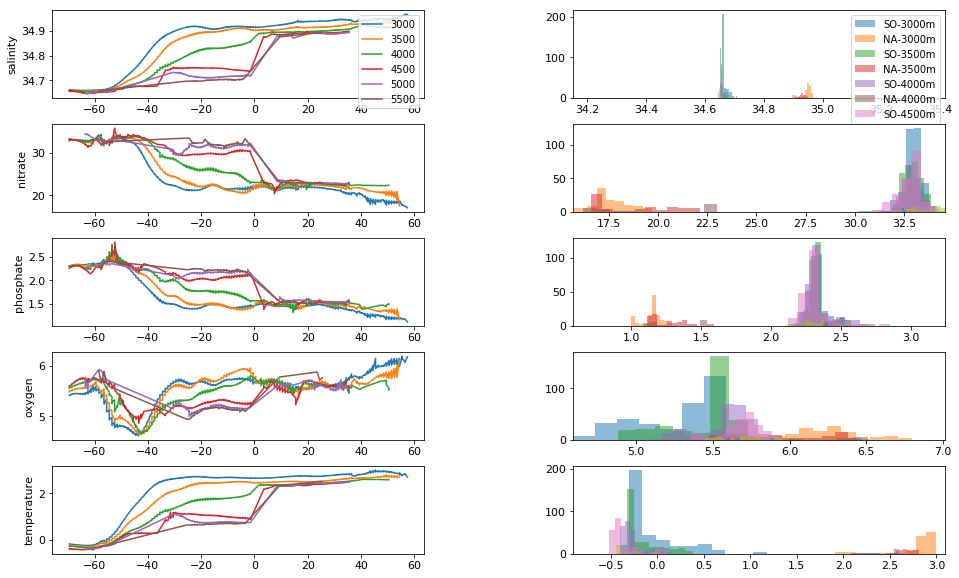

In [13]:
# for all tracers
tracers = ['salinity', 'nitrate', 'phosphate', 'oxygen', 'temperature']
lineLon = -25
minLat, maxLat = -70, 80

fig = plt.figure(figsize=(10+6, 10))
gs = gridspec.GridSpec(len(tracers),2, width_ratios=[1,1], wspace=0.4, hspace = 0.3) 
ax_out = []
for ik in range(len(tracers)*2):
    ax_out.append(fig.add_subplot(gs[ik]))

for ik, tracer in enumerate(tracers):
    print(tracer)
    dataset_NA = dataFetcher()
    dataset_NA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <70 and latitude > 50 and longitude < -20 and longitude >-40 order by depth'.format(tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')

    NAtl_60 = water_column(dataset_NA, 'column')
    NAtl_60.get_char_values()

    dataset_SA = dataFetcher()
    dataset_SA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <-50 and latitude > -70 and longitude < -20 and longitude >-40 order by depth'.format(tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')

    SAtl_60 = water_column(dataset_SA, 'column')
    SAtl_60.get_char_values()
    
    section_dataset = dataFetcher()
    section_dataset.get_section('NS_section', lineLon, [minLat, maxLat], [tracer])

    depths = [3000, 3500, 4000, 4500, 5000, 5500]
    for depth in depths:
        data_NA = dataset_NA._feat_data[dataset_NA._d==depth]
        data_SA = dataset_SA._feat_data[dataset_SA._d==depth]
        ax_out[2*ik+1].hist(data_SA, label = 'SO-'+ str(depth)+'m', alpha=.5)
        ax_out[2*ik+1].hist(data_NA, label = 'NA-'+ str(depth)+'m', alpha = .5)
        t2, p2 = stats.ttest_ind(data_NA,data_SA, equal_var=False)
        ax_out[2*ik].plot(section_dataset._x[section_dataset._d==depth], section_dataset._feat_data[section_dataset._d==depth], label=str(depth))
        print('\t',depth, t2, p2)
        ax_out[2*ik].set_ylabel(tracer)
        try:
            ax_out[2*ik+1].set_xlim([min([min(data_NA), min(data_SA)])-.5, max([max(data_NA), max(data_SA)])+.5])
        except:
            continue
    if ik == 0:
        ax_out[2*ik+1].legend(prop={'size': 10})
        ax_out[2*ik].legend(prop={'size': 10})
# fig

name2 = 'tracer_hist_lonTraj_Atl'
plt.savefig(path+name2+'.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)



Great, so we can see that, with the exception of oxygen which is strongly affected by a number of processes, water is fairly consistent all the way through the water column at high latitudes, but that there's a departure in the mid latitutdes where the upper part of the water column (say, above 3500m) looks like the North Atlantic, while the bottom part of the water column (below 4500m) looksl ike the Southern Ocean (South Atlantic).  The trajectory for 4000m is pretty diagonal, connecting the high latitude values, suggesting that this is the depth (approximately) where mixing is happening at the margins between watermasses.  

In [31]:
#need to fix so that there aren't multiple points for a lat/lon/depth location
dataset_tr = dataFetcher()
dataset_tr.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 order by {},{},{}'.format(tracer,'latitude', 'longitude', 'depth'),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')

['other']


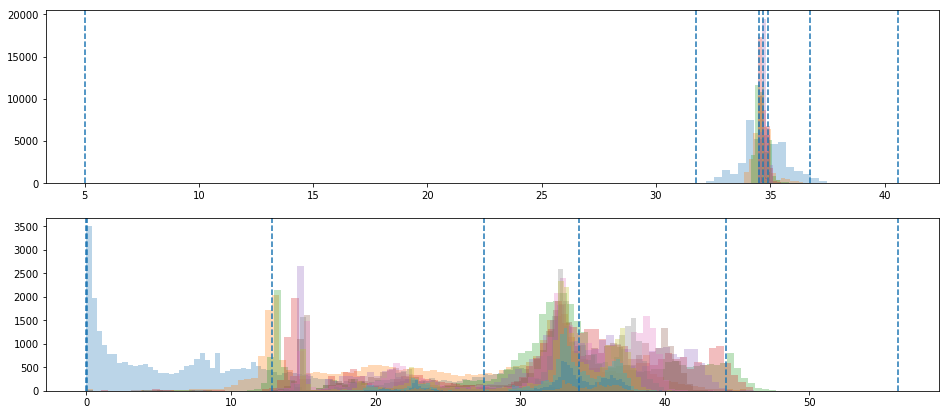

In [66]:
tracers = ['salinity', 'nitrate']
newPlot = rawPlotter(['other'], tracers)
fig, ax_out = newPlot.make()

for ik, tracer in enumerate(tracers):
#     dataset_tr = dataFetcher()
#     dataset_tr.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 order by {},{},{}'.format(tracer,'latitude', 'longitude', 'depth'),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')
    
#     print(len(ax_out))

    dataset_tr = dataFetcher()
    dataset_tr.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 order by {}'.format(tracer, tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')

    depths = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500]
    for depth in depths:
        ax_out[ik].hist(dataset_tr._feat_data[dataset_tr._d == depth], 100, alpha = .3, label= str(depth))
        
    p_min = 0
    p_01= int(np.floor(.01*len(dataset_tr._feat_data)))
    p_25 = int(np.floor(.25*len(dataset_tr._feat_data)))
    p_5 = int(np.floor(.5*len(dataset_tr._feat_data)))
    p_75 = int(np.floor(.75*len(dataset_tr._feat_data)))
    p_99 = int(np.floor(.99*len(dataset_tr._feat_data)))
    p_max = len(dataset_tr._feat_data)-1

#     ax_out[ik].hist(dataset_tr._feat_data, 100, alpha = .3)
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_01], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_25], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_5], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_75], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_99], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_min], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_max], linestyle='--')

ax_out[0].legend(prop={'size': 10})

['other']


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


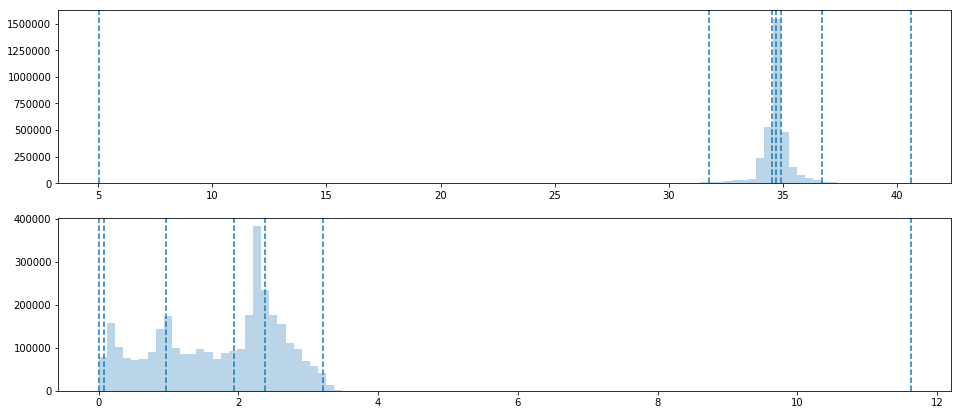

In [133]:
tracers = ['salinity', 'phosphate']
newPlot = rawPlotter(['other'], tracers)
fig, ax_out = newPlot.make()

for ik, tracer in enumerate(tracers):
#     dataset_tr = dataFetcher()
#     dataset_tr.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 order by {},{},{}'.format(tracer,'latitude', 'longitude', 'depth'),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')
    
#     print(len(ax_out))

    dataset_tr = dataFetcher()
    dataset_tr.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 order by {}'.format(tracer, tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')

#     depths = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500]
#     for depth in depths:
    ax_out[ik].hist(dataset_tr._feat_data, 100, alpha = .3)
        
    p_min = 0
    p_01= int(np.floor(.01*len(dataset_tr._feat_data)))
    p_25 = int(np.floor(.25*len(dataset_tr._feat_data)))
    p_5 = int(np.floor(.5*len(dataset_tr._feat_data)))
    p_75 = int(np.floor(.75*len(dataset_tr._feat_data)))
    p_99 = int(np.floor(.99*len(dataset_tr._feat_data)))
    p_max = len(dataset_tr._feat_data)-1

#     ax_out[ik].hist(dataset_tr._feat_data, 100, alpha = .3)
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_01], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_25], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_5], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_75], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_99], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_min], linestyle='--')
    ax_out[ik].axvline(x = dataset_tr._feat_data[p_max], linestyle='--')

ax_out[0].legend(prop={'size': 10})

12.8107 27.531 34.0684
0.61740912496
0.0287341365526


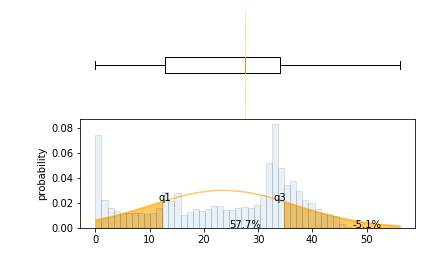

In [24]:
import numpy as np
import scipy
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf

# dummy data
mu = np.mean(dataset_tr._feat_data)
sigma = np.std(dataset_tr._feat_data)
n_bins = 50
s = dataset_tr._feat_data#np.random.normal(mu, sigma, 1000)

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

#histogram
n, bins, patches = axes[1].hist(s, n_bins, normed=True, alpha=.1, edgecolor='black' )
pdf = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(bins-mu)**2/(2*sigma**2))

median, q1, q3 = np.percentile(s, 50), np.percentile(s, 25), np.percentile(s, 75)
print(q1, median, q3)

#probability density function
axes[1].plot(bins, pdf, color='orange', alpha=.6)

#to ensure pdf and bins line up to use fill_between.
bins_1 = bins[(bins >= q1-1.5*(q3-q1)) & (bins <= q1)] # to ensure fill starts from Q1-1.5*IQR
bins_2 = bins[(bins <= q3+1.5*(q3-q1)) & (bins >= q3)]
pdf_1 = pdf[:int(len(pdf)/2)]
pdf_2 = pdf[int(len(pdf)/2):]
pdf_1 = pdf_1[(pdf_1 >= norm(mu,sigma).pdf(q1-1.5*(q3-q1))) & (pdf_1 <= norm(mu,sigma).pdf(q1))]
pdf_2 = pdf_2[(pdf_2 >= norm(mu,sigma).pdf(q3+1.5*(q3-q1))) & (pdf_2 <= norm(mu,sigma).pdf(q3))]

#fill from Q1-1.5*IQR to Q1 and Q3 to Q3+1.5*IQR
axes[1].fill_between(bins_1, pdf_1, 0, alpha=.6, color='orange')
axes[1].fill_between(bins_2, pdf_2, 0, alpha=.6, color='orange')

print(norm(mu, sigma).cdf(median))
print(norm(mu, sigma).pdf(median))

#add text to bottom graph.
axes[1].annotate("{:.1f}%".format(100*norm(mu, sigma).cdf(q1)), xy=((q1-1.5*(q3-q1)+q1)/2, 0), ha='center')
axes[1].annotate("{:.1f}%".format(100*(norm(mu, sigma).cdf(q3)-norm(mu, sigma).cdf(q1))), xy=(median, 0), ha='center')
axes[1].annotate("{:.1f}%".format(100*(norm(mu, sigma).cdf(q3+1.5*(q3-q1)-q3)-norm(mu, sigma).cdf(q3))), xy=((q3+1.5*(q3-q1)+q3)/2, 0), ha='center')
axes[1].annotate('q1', xy=(q1, norm(mu, sigma).pdf(q1)), ha='center')
axes[1].annotate('q3', xy=(q3, norm(mu, sigma).pdf(q3)), ha='center')

axes[1].set_ylabel('probability')

#top boxplot
axes[0].boxplot(s, 0, 'gD', vert=False)
axes[0].axvline(median, color='orange', alpha=.6, linewidth=.5)
axes[0].axis('off')

plt.subplots_adjust(hspace=0)
plt.show()

['other', 'plan']
4
0.6251819133758545
0.3963358402252197


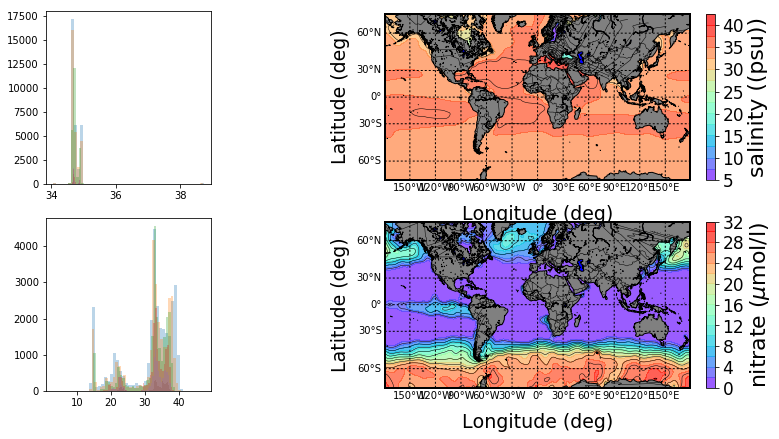

In [19]:
tracers = ['salinity', 'nitrate']#, 'phosphate', 'oxygen', 'temperature']
    
newPlot = rawPlotter(['other', 'plan'], tracers)
fig, ax_out = newPlot.make()
print(len(ax_out))
for ik, tracer in enumerate(tracers):
    
    dataset_tr = dataFetcher()
    dataset_tr.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 '.format(tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')
    depths = [3000, 3500, 4000, 4500, 5000, 5500]
    for depth in depths:
        ax_out[2*ik].hist(dataset_tr._feat_data[dataset_tr._d == depth], 50, alpha = .3)
    
    ptlat = 43.5
    ptlon = 39.5

    minlat, maxlat, minlon, maxlon = -70, 70,-180, 180
    dpth = 0

    dataset_tr2 = dataFetcher()
    dataset_tr2.get_plan([minlat, maxlat],[minlon, maxlon], [tracer], dpth)

    fig, ax_out[2*ik+1] = newPlot.add_plan(fig, ax_out[2*ik+1], dataset_tr2, tracer, dpth)


In [13]:
print('North Atlantic v. Mid Atlantic')
# print('2000', stats.ttest_ind(s00,n00, equal_var=False))
print('2500 ma and 3000 na', stats.ttest_ind(d_e_n[2500],d_n[3000], equal_var=False))
print('3000 ma and 3500 na', stats.ttest_ind(d_e_n[3000],d_n[3500], equal_var=False))
print('3500 ma and 4000 na', stats.ttest_ind(d_e_n[3500],d_n[4000], equal_var=False))
print('4000 ma and 4500 na', stats.ttest_ind(d_e_n[4000],d_n[4500], equal_var=False))
# print('4500', stats.ttest_ind(v4,n4, equal_var=False))

North Atlantic v. Mid Atlantic
2500 ma and 3000 na Ttest_indResult(statistic=-2.6237678440215921, pvalue=0.015124653092712471)
3000 ma and 3500 na Ttest_indResult(statistic=-4.3828226949596241, pvalue=0.00022958015401044205)
3500 ma and 4000 na Ttest_indResult(statistic=-4.7935234716786512, pvalue=0.0091849419620215929)
4000 ma and 4500 na Ttest_indResult(statistic=nan, pvalue=nan)


Water from the North Atlantic (north of 30N) at 3000m, 3500m, 4000m, and 4500m is indistinguishable (by ptest) from low latitude (0-20N) water at 2500m, 3000m, 3500m, and 4000m respectively.  This suggests that there are layers of homogenous water that extend from the North Atlantic to the Mid Atlantic moving up the water column slightly from North to South  

In [15]:
print('Mid Atlantic north v. Mid Atlantic South; upward trajectory?')
# print('2000', stats.ttest_ind(s00,n00, equal_var=False))
print('2000 ma s and 2500 ma n', stats.ttest_ind(d_lm_s[2000],d_lm_n[2500], equal_var=False))
print('2500 ma s and 3000 ma n', stats.ttest_ind(d_lm_s[2500],d_lm_n[3000], equal_var=False))
print('3000 ma s and 3500 ma n', stats.ttest_ind(d_lm_s[3000],d_lm_n[3500], equal_var=False))
print('3500 ma s and 4000 ma n', stats.ttest_ind(d_lm_s[3500],d_lm_n[4000], equal_var=False))
print('4000 ma s and 4500 ma n', stats.ttest_ind(d_lm_s[4000],d_lm_n[4500], equal_var=False))
# print('4500', stats.ttest_ind(v4,n4, equal_var=False))

Mid Atlantic north v. Mid Atlantic South; upward trajectory?
2000 ma s and 2500 ma n Ttest_indResult(statistic=-0.82024918002238312, pvalue=0.41693344521405429)
2500 ma s and 3000 ma n Ttest_indResult(statistic=-0.38460771412972994, pvalue=0.70322133096591477)
3000 ma s and 3500 ma n Ttest_indResult(statistic=4.4424545627094396, pvalue=9.4546505442574187e-05)
3500 ma s and 4000 ma n Ttest_indResult(statistic=2.9169925998968433, pvalue=0.0068072554043116049)
4000 ma s and 4500 ma n Ttest_indResult(statistic=-17.419208932256716, pvalue=1.6471532642009085e-18)


In [16]:
print('Mid Atlantic north v. Mid Atlantic South; level trajectory?')
# print('2000', stats.ttest_ind(s00,n00, equal_var=False))
print('2500 ma s and 3000 ma n', stats.ttest_ind(d_lm_s[3000],d_lm_n[3000], equal_var=False))
print('3000 ma s and 3500 ma n', stats.ttest_ind(d_lm_s[3500],d_lm_n[3500], equal_var=False))
print('3500 ma s and 4000 ma n', stats.ttest_ind(d_lm_s[4000],d_lm_n[4000], equal_var=False))
print('4000 ma s and 4500 ma n', stats.ttest_ind(d_lm_s[4500],d_lm_n[4500], equal_var=False))
# print('4500', stats.ttest_ind(v4,n4, equal_var=False))

Mid Atlantic north v. Mid Atlantic South; level trajectory?
2500 ma s and 3000 ma n Ttest_indResult(statistic=-5.3294905237651751, pvalue=1.7534673830823724e-05)
3000 ma s and 3500 ma n Ttest_indResult(statistic=-4.4646571732931184, pvalue=6.621914385625354e-05)
3500 ma s and 4000 ma n Ttest_indResult(statistic=-23.6742202980865, pvalue=1.1781648927165416e-18)
4000 ma s and 4500 ma n Ttest_indResult(statistic=-70.126457973822355, pvalue=3.2480744512990488e-23)


In [638]:
print('Mid Atlantic South v. Southern Ocean; level trajectory?')
# print('2000', stats.ttest_ind(s00,n00, equal_var=False))
print('3000 ma s and 3000 s', stats.ttest_ind(d_um_s[3000],d_s[3000], equal_var=False))
print('3500 ma s and 3500 s', stats.ttest_ind(d_um_s[3500],d_s[3500], equal_var=False))
print('4000 ma s and 4000 s', stats.ttest_ind(d_um_s[4000],d_s[4000], equal_var=False))
print('4500 ma s and 4500 s', stats.ttest_ind(d_um_s[4500],d_s[4500], equal_var=False))
# print('4500', stats.ttest_ind(v4,n4, equal_var=False))

Mid Atlantic South v. Southern Ocean; level trajectory?
3000 ma s and 3000 s Ttest_indResult(statistic=2.3171727239650388, pvalue=0.043932874425457208)
3500 ma s and 3500 s Ttest_indResult(statistic=3.7783152669614704, pvalue=0.0065821188575210104)
4000 ma s and 4000 s Ttest_indResult(statistic=-1.5585540408274363, pvalue=0.14788444557619398)
4500 ma s and 4500 s Ttest_indResult(statistic=-0.62659257689112369, pvalue=0.54447199849671812)


ptests suggest that water down to 4000m is different laterally from 63 to 53, but that water below 4000 is spreading northward (water is indistinguishable in the deep ocean between 63 and 53

In [639]:
print('Mid Atlantic South v. Southern Ocean; downward (as going north) trajectory?')
# print('2000', stats.ttest_ind(s00,n00, equal_var=False))
print('3000 s and 3500 ma s', stats.ttest_ind(d_um_s[3500],d_s[3000], equal_var=False))
print('3500 s and 4000 ma s', stats.ttest_ind(d_um_s[4000],d_s[3500], equal_var=False))
print('4000 s and 4500 ma s', stats.ttest_ind(d_um_s[4500],d_s[4000], equal_var=False))
print('4500 s and 5000 ma s', stats.ttest_ind(d_um_s[5000],d_s[4500], equal_var=False))
# print('4500', stats.ttest_ind(v4,n4, equal_var=False))

Mid Atlantic South v. Southern Ocean; downward (as going north) trajectory?
3000 s and 3500 ma s Ttest_indResult(statistic=-0.093020591616892842, pvalue=0.92798770568119815)
3500 s and 4000 ma s Ttest_indResult(statistic=0.5080288407841318, pvalue=0.62604577373383119)
4000 s and 4500 ma s Ttest_indResult(statistic=-4.3892063240363486, pvalue=0.0035918555960780725)
4500 s and 5000 ma s Ttest_indResult(statistic=1.4040901780980626, pvalue=0.19396594734820816)


In [364]:
# consider the water column sections as described as the depths where change is happenening slowly, are the sections distinct with 90% confidence?
data1 = dataset2._feat_data[dataset2._d>_d[extrema2][-1]]
data2 = dataset2._feat_data[(_d[extrema2][-1]>dataset2._d) &(dataset2._d >_d[extrema2][-2])]
t2, p2 = stats.ttest_ind(data1,data2, equal_var=False)
print(t2, p2)

data3 = dataset2._feat_data[(_d[extrema2][-2]>dataset2._d) &(dataset2._d >_d[extrema2][-3])]
t3, p3 = stats.ttest_ind(data2,data3, equal_var=False)
print(t3, p3)

data4 = dataset2._feat_data[(dataset2._d <_d[extrema2][-3])]
t4, p4 = stats.ttest_ind(data3,data4, equal_var=False)
print(t4, p4)

nan nan
-6.76379378562 1.56231226583e-10
-11.9328740305 1.7578582905e-25


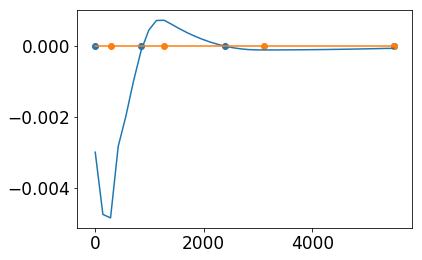

In [363]:
plt.plot(_d, _feat_data_prime)
plt.plot(_d, np.zeros(len(_feat_data_prime)))
plt.scatter(_d[extrema1], np.zeros(len(extrema1))) #max and min of concentration; d/d[a] = 0
plt.scatter(_d[extrema2], np.zeros(len(extrema2))) #max and min of rate of concentration change; d/d[a] = 0

In [366]:
#characteristic values (values at depths where the concentration doesn't change):
char_values = []
depths = []
for ik in range(len(extrema1)):
    depth = round(_d[extrema1][ik],-1)
    char_value = np.mean(dataset2._feat_data[dataset2._d == depth])
    if (char_value >0) == False:
        depth = round(_d[extrema1][ik] / 50.0) * 50.0
        char_value = np.mean(dataset2._feat_data[dataset2._d == depth])
    char_values.append(char_value)
    depths.append(depth)

build a mixing model for layers on top of each other using the max and min values of the _feat_data as characteristic values.  Whichever watermass has > 50% owns the point. 

s = c1*s1 +c2*s2 
o = c1*o1 +c2*o2

solve for c1, c2

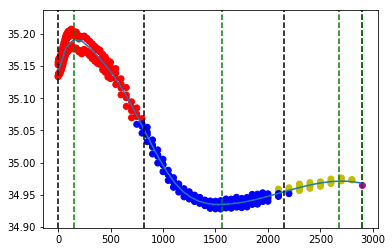

In [136]:
plt.scatter(dataset2._d, dataset2._feat_data, c=NAtl_60.mixing_labels)
plt.plot(NAtl_60._d_smooth, NAtl_60._feat_data_smooth)
for extrema in NAtl_60.extrema_d2:
    plt.axvline(NAtl_60._d_smooth[extrema], color='k', linestyle='--')
for extrema in NAtl_60.extrema_d1:
    plt.axvline(NAtl_60._d_smooth[extrema], color='g', linestyle='--')

In [288]:
#comparing datasets from different locations
data1 = dataset._feat_data[dataset._d>np.sort(_d[extrema2])[-1]]
data1 = dataset._feat_data[dataset._d>_d[extrema2][-1]]


data2 = dataset2._feat_data[dataset2._d>np.sort(_d[extrema2])[-1]]
print((np.mean(data1)-np.mean(data2))/(np.std(data1)**2/len(data1)+np.std(data2)**2/len(data2))**(1/2))
t2, p2 = stats.ttest_ind(data1,data2, equal_var=False)
t2, p2

0.311909901056


(0.30857520092498314, 0.75862767489261529)

In [362]:
#smoothing and extrema

_d = []
_feat_data = []

for ik in range(len(dataset2._d)):
    if dataset2._d[ik] not in _d:
        _d.append(dataset2._d[ik])
        #change this to pull the median value if there are multiple values for a given depth
        _feat_data.append(dataset2._feat_data[ik])

spl = UnivariateSpline(_d, _feat_data)
spl.set_smoothing_factor(0.05)

numpts = 40
_d = np.linspace(0, max(_d), num=numpts, endpoint=True)
_feat_data = spl(_d)

_feat_data_prime = np.gradient(_feat_data,_d)

extrema1 = np.sort(np.concatenate([argrelextrema(_feat_data, np.greater, mode="wrap")[0], argrelextrema(_feat_data, np.less, mode="wrap")[0]]))
extrema2 = np.sort(np.concatenate([argrelextrema(_feat_data_prime, np.greater, mode="wrap")[0], argrelextrema(_feat_data_prime, np.less, mode="wrap")[0]]))


5500.0 5500.0
